# Testing Computer Image Classification Capabilities As They Relate to CAPTCHAs

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRosXhdSSpG8YL-BsstKGKdtP6ETGIwPfDOhA&s)

# Table of Contents
1. Problem Description
2. Dataset Description
3. Possible Aproaches
4. Code
5. Summary of Results & Conclusion
6. References

# Problem Description
A Turing test is designed to differentiate between computers and humans. CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart) have been employed for this purpose in various forms. In the past, they primarily revolved around obscured, jumbled text. They now more commonly deal with identifying which tiles of an image contain an object. Attempting this problem will shed some insight into this crucial process. Machine learning techniques, such as artifical neural networks (ANNs) are on the cutting-edge of solving these sorts problems, being that they seek to emulate the human brain.

# Dataset Description
https://www.kaggle.com/datasets/maricinnamon/caltech101-airplanes-motorbikes-schooners

The dataset is a sample of a much larger one provided by researchers at Caltech (known as the Caltech101 dataset). This dataset  It is composed of images of three classes: airplanes, motorbikes, and schooners (a kind of boat). There are 1,660 instances (images) in total; approximately 800 of these are airplanes, 800 are motorbikes, and 60 schooners. These image classes are similar to those that would be found in CAPTCHAs. The images are in RGB and are of varying size, though they are similarly sized (roughly 300 x 200 pixels). NOTE: Image samples will be shown later in this notebook.

# Possible Approaches
1. Deep neural network (DNN) without any convolutional layers
2. Convolutional neural network (CNN)
3. Transfer learning

The problem suggests this is a multiclass classification task, since there are multiple classes that must be classified appropriately. It is also a computer vision task because it involves training a model to identify and understand images. The usage of a convolutional neural network (CNN) immediately comes to mind, since CNNs excel at computer vision tasks. Perhaps the results of a CNN model could be compared to a deep neural network to evaluate and quantify the improvements. Transfer learning could make use of a pre-trained model to improve generalization in this task.

# Code

**Setup**

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# More imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
import tensorflow_hub as hub
from tensorflow.keras.applications import Xception
import matplotlib.pyplot as plt

**Load & Preprocess the Data**

The following code uses the ImageDataGenerator class to load and augment the image data, as well as define data flows for training, validation, and testing. Data augmention is important for improving the generalization capabilities of the model. However, the test data is not augmented to reflect real-world data.

In [14]:
# Set the seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define base directory path
base_dir = "/kaggle/input/caltech101-airplanes-motorbikes-schooners/caltech101_classification/"

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1/255., rotation_range=20, shear_range=0.2,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True,
                                   validation_split=0.2)  # 20% for validation

test_datagen = ImageDataGenerator(rescale=1/255.)

# Setup training and validation generators
train_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

# Setup test generator
test_generator = test_datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 1330 images belonging to 3 classes.
Found 331 images belonging to 3 classes.
Found 1661 images belonging to 3 classes.


**Training Set Samples**

In [ ]:
# Fetch a batch of images from the train_generator
x_batch, y_batch = next(train_generator)

# Assuming the class_indices are as defined in your generator
class_labels = list(train_generator.class_indices.keys())

# Display images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axes = axes.flatten()
for img, label, ax in zip(x_batch, y_batch, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(class_labels[np.argmax(label)])
plt.tight_layout()
plt.show()

**Test Set Samples**

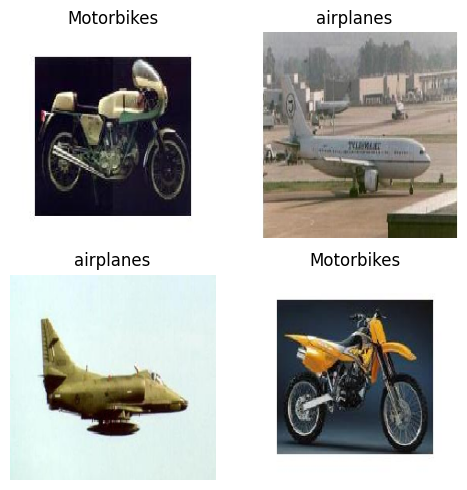

In [16]:
# Re-define batches with test generator
x_batch, y_batch = next(test_generator)
# Display images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axes = axes.flatten()
for img, label, ax in zip(x_batch, y_batch, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(class_labels[np.argmax(label)])
plt.tight_layout()
plt.show()

**Model Building**

The model's architecture is as follows:
1. Input layer: (224, 224, 3) for the height, width, and number of color channels.
2. Conv2D layers: These have a kernel size of (3, 3) and use the ReLu activation function. These layers are intended to extract the features from the input images.
3. MaxPool2D layers: These layers reduce the spatial dimensions of the convolutional layers' output. These seek to reduce overfitting by abstracting high-level features and overall reducing computational load.
4. Flatten layer: Converts 2D feature maps into a 1D feature vector.
5. Dense (output) layer: This is a fully connected layer that uses the softmax activation function to output a probability.

Further, the model is fitted with callbacks, ensuring model weights are saved only when their performance on the validation set improves.

In [17]:
# Define model
model = Sequential([
    Input(shape=(224, 224, 3)), # Explicitly define shape to avoid errors
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit model with callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_best.keras", save_best_only=True)
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint_cb])

Epoch 1/10
 1/42 ━━━━━━━━━━━━━━━━━━━━ 3:21 5s/step - accuracy: 0.0312 - loss: 1.1383

W0000 00:00:1715290772.860911     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5869 - loss: 0.7670

W0000 00:00:1715290787.756895     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 450ms/step - accuracy: 0.5944 - loss: 0.7594 - val_accuracy: 0.6133 - val_loss: 0.9461
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.9084 - loss: 0.3244 - val_accuracy: 0.7069 - val_loss: 0.7317
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - accuracy: 0.9252 - loss: 0.2768 - val_accuracy: 0.7462 - val_loss: 0.7324
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.9382 - loss: 0.2067 - val_accuracy: 0.8338 - val_loss: 0.4466
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.9170 - loss: 0.2556 - val_accuracy: 0.7613 - val_loss: 0.7869
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.9379 - loss: 0.1943 - val_accuracy: 0.7583 - val_loss: 0.7200
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.9478 - loss: 0.1752 - val_accuracy: 0.7704 - val_loss: 0.6129
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.9535 - loss: 0.1556 - val_accuracy: 0.839

Finally, the CNN model can be evaluated:

In [18]:
# Evaluate model
model = load_model("model_best.keras")
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

 4/52 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9499 - loss: 0.1899 

W0000 00:00:1715290976.459858     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9340 - loss: 0.1946
Test accuracy: 0.9331727623939514


**Transfer Learning With Xception**

The Xception CNN model is a 71-layer pretrained model trained on the ImageNet dataset. This dataset contains millions of images of around 1000 classes. The default input image size for this model is 299x299, which is different from the 224x224 that has been used up to this point. Therefore, I changed the input image size for this iteration accordingly:

In [19]:
# Setup training and validation generators
train_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(299, 299), batch_size=32, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(299, 299), batch_size=32, class_mode='categorical', subset='validation')

# Setup test generator
test_generator = test_datagen.flow_from_directory(
    base_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')

Found 1330 images belonging to 3 classes.
Found 331 images belonging to 3 classes.
Found 1661 images belonging to 3 classes.


The Xception model is loaded without the top (final classification layer) so that the model can be used as a feature extractor. The classification layers can be added on after the fact. These additional layers are:
1. Global Average Pooling 2D layer: Reduces feature maps to a single value.
2. Dense (output) layer: Fully connected layer using the softmax activation function.

In [23]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False,
                                                    input_shape=(299, 299, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Freeze the weights of pretrained layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
xceptionHistory = model.fit(train_generator,
                            epochs=4,
                            validation_data=validation_generator)    

Epoch 1/4


W0000 00:00:1715292620.033963     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/42 ━━━━━━━━━━━━━━━━━━━━ 5s 855ms/step - accuracy: 0.8030 - loss: 0.5926

W0000 00:00:1715292649.213765     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.8237 - loss: 0.5430

W0000 00:00:1715292655.877917     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8262 - loss: 0.5368 - val_accuracy: 0.9637 - val_loss: 0.1244
Epoch 2/4


W0000 00:00:1715292663.575995     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 764ms/step - accuracy: 0.9989 - loss: 0.0336 - val_accuracy: 0.9668 - val_loss: 0.0869
Epoch 3/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 768ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.9819 - val_loss: 0.0594
Epoch 4/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9758 - val_loss: 0.0583


NOTE: Usually, with the top layers well trained at this point, the base model's top layers are unfrozen for continued training. However, I elected to skip this step since the validation accuracy was already so high.

Finally, the model can be evaluated:

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.9975 - loss: 0.0131
Test accuracy: 0.9981938600540161


W0000 00:00:1715291154.959322     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Summary of Results & Conclusion

**CNN Approach**

95% accuracy.

**Transfer Learning (Xception) Approach**

99% accuracy (a 5% improvement over the CNN).

**Conclusion**

Both approaches were effective at solving the image classification part of the CAPTCHA. In fact, "a 2014 study by Google found that AI robots were able to decode the CAPTCHAs with 99.8% accuracy, and numbers in images with 90%." (Hunter-Cozens, 2018 sec. CAPTCHA's Decline). To combat this, Google (the owner of CAPTCHA since 2009), has resorted to employing its risk analysis engine to anaylize the user's behavior throughout the website.

The images below show the evolution of CAPTCHAs over time, with increasingly complex images to classify:

![](https://cf-assets.www.cloudflare.com/slt3lc6tev37/3pwMuJ55jpErAafgrWbyTr/e6c487ac6e4288dfe284db72b88ea3d1/captcha.png)

Figure 1: Early text-based CAPTCHA

![](https://miro.medium.com/v2/resize:fit:1080/1*7D51cnc3qL-ftIWfoz2Bqw.jpeg)

Figure 2: Intermediate image classification CAPTCHA

![](https://www.evina.com/wp-content/uploads/2020/12/Screenshot-2020-12-17-at-19.38.11.png)

Figure 3: Tile-based image classification CAPTCHA

# References

Antonevych, M. (2022, September 14). Caltech101: Airplanes, Motorbikes & Schooners. Kaggle. https://www.kaggle.com/datasets/maricinnamon/caltech101-airplanes-motorbikes-schooners/data 

Azlan, N. (2023, July 13). Aeromotoship - Image Classification. Kaggle. https://www.kaggle.com/code/nasruddinaz/aeromotoship-image-classification 

deeplizard. (2017, December 9). Convolutional Neural Networks (cnns) explained. YouTube. https://www.youtube.com/watch?v=YRhxdVk_sIs 

Google. (n.d.). Machine Learning Crash Course with TensorFlow APIs. Google Machine Learning. https://developers.google.com/machine-learning/crash-course 

Géron, A. (2023). Hands-On Machine Learning With Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (3rd ed.). O’Reilly. 

Hunter-Cozens, G. (2018, September 18). The Evolution of CAPTCHA. Adapt. https://www.adaptworldwide.com/insights/2018/the-evolution-of-captcha 

Li, F.-F., Andreeto, M., Ranzato, M., & Perona, P. (2022). Caltech 101 (1.0) [Data set]. CaltechDATA. https://doi.org/10.22002/D1.20086 